In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
%matplotlib inline

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import binarize
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_classif, mutual_info_classif

In [55]:
%%writefile learner2.py
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import binarize
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_classif, mutual_info_classif, f_regression, SelectPercentile

class RubygemLearner(object):
    def __init__(self, fn):
        with open(fn) as f:
            data = json.load(f)
        self.data = data["data"]
        self.spec = data["spec"]
        self.df = pd.io.json.json_normalize(self.data)
        self.features = self.exclude_unwanted_features()
        self._rename_columns()
        self.df = self.df[self.df["avg_nloc"]<20]
            
    def exclude_unwanted_features(self):
        exclude = []#'nloc',] #+ reek_columns + lizard_columns #+ reek_columns
        return [k for k, v in self.data[0]['stat'].items() if k not in exclude]
        
    def remove_too_small_changes(self):
        try:
            df = df.groupby('name').filter(lambda x: x['delta_nloc'].sum() >2000)
        except:
            pass
    
    def summary(self):
        print(self.spec)
        print('nb_records:', len(self.df))
        print("abandoned:", (self.df['label'] != 'maintained').sum())
        
    def feature_evaluation(self):
        X = self.df[self.features]
        y = (self.df.label == 'maintained').values.astype(int)
        X_new = SelectKBest(f_classif, k=10).fit(X, y)
        feature_list = np.array([X_new.scores_.astype(float), self.features]).T
        feature_list=[[float(x[0]), x[1]] for x in feature_list]
        return sorted(feature_list, key=lambda a_entry: a_entry[0], reverse=True )
        
    def _rename_columns(self):
        old_new_cols = {}
        for name in self.df.columns:
            if name.startswith('stat'):
                old_new_cols[name] = name.split('.')[1]
        self.df.rename(columns=old_new_cols, inplace=True)
        
    def my_train_test_split(self, test_size=0.3):
        Xgems = self.df[["name"]].drop_duplicates()
        X_train_gems, X_test_gems = train_test_split(Xgems, test_size=test_size)
        X_train = self.df[self.df['name'].isin(X_train_gems['name'])]
        y_train = (X_train.label == 'maintained').values.astype(int)
        X_train = X_train[self.features]
        dftest = self.df[self.df['name'].isin(X_test_gems['name'])]

        return X_train, y_train, dftest

class Trainer(object):
    def __init__(self, learner):
        self.learner = learner
        
    def predict_sequence(self, estimator, df, name, label, threshold=0.5):
        X = df[df['name']==name][df['label']==label][self.learner.features]
        y_pred = estimator.predict(X)
        return 0 if np.mean(y_pred) < threshold else 1

    def test_model(self, model, dftest):
        estimator = model
        testers = dftest[["name", "label"]].drop_duplicates()
        y_test = (testers.label == 'maintained').values.astype(int)
        y_pred = [self.predict_sequence(estimator, dftest, t[0], t[1]) for t in testers.values]
        #print(y_pred)
        #print(y_test)
        #print(metrics.classification_report(y_test, y_pred))
        return metrics.accuracy_score(y_test, y_pred)

    def train_and_test(self, model):
        accuracies = []
        for i in range(5):
            X_train, y_train, test = self.learner.my_train_test_split(test_size=0.3)
            model.fit(X_train, y_train)
            accuracies.append(self.test_model(model, test))
        return np.mean(accuracies)
    

Writing learner2.py


In [54]:
from learner import RubygemLearner

In [4]:
import json

fn = 'RubygemDigger--Steps--GenerateJsonForLastVersions--2.data.json'
fn = 'RubygemDigger--Steps--GenerateJsonForAllVersions--1.data.json.all.json'

learner = RubygemLearner(fn)
learner.summary()
print(learner.feature_evaluation())

{'version': 1, 'description': 'most data', 'min_number_of_gems': 12, 'min_months': 10, 'min_nloc': 2000, 'min_months_good': 20, 'history_months': 10, 'stopped_time_point': '2015-01-01 00:00:00 UTC', 'ignored_months_for_good': 10}
nb_records: 9968
abandoned: 3819
[['20.83904074719494' 'nloc']
 ['22.793168028098954' 'avg_ccn']
 ['7.652223163799252' 'avg_nloc']
 ['3.0333366370115975' 'avg_token']
 ['40.20437310685042' 'fun_count']
 ['53.426880023707774' 'warning_count']
 ['40.59749253101271' 'fun_rate']
 ['17.904624546236967' 'nloc_rate']
 ['108.1601881490984' 'style_']
 ['127.35050621783235' 'performance_']
 ['48.479367953951815' 'security_']
 ['286.12976744783947' 'lint_']
 ['102.37045052923294' 'lint_duplicate']
 ['53.14334521323146' 'metrics_']
 ['53.684523545476225' 'metrics_abcsize']
 ['11.881953071591333' 'metrics_blocklength']
 ['0.048796006359738464' 'metrics_blocknesting']
 ['101.23985868390126' 'metrics_classlength']
 ['88.825071314669' 'metrics_cyclomaticcomplexity']
 ['1.3027

In [5]:
reek_columns =[
    'reek_total',
 'Attribute',
 'BooleanParameter',
 'ClassVariable',
 'ControlParameter',
 'DataClump',
 'DuplicateMethodCall',
 'FeatureEnvy',
 'InstanceVariableAssumption',
 'IrresponsibleModule',
 'LongParameterList',
 'LongYieldList',
 'ManualDispatch',
 'ModuleInitialize',
 'NestedIterators',
 'NilCheck',
 'PrimaDonnaMethod',
 'RepeatedConditional',
 'SubclassedFromCoreClass',
 'TooManyConstants',
 'TooManyInstanceVariables',
 'TooManyMethods',
 'TooManyStatements',
 'UncommunicativeMethodName',
 'UncommunicativeModuleName',
 'UncommunicativeParameterName',
 'UncommunicativeVariableName',
 'UnusedParameters',
 'UtilityFunction',
 'delta_Attribute',
 'delta_BooleanParameter',
 'delta_ClassVariable',
 'delta_ControlParameter',
 'delta_DataClump',
 'delta_DuplicateMethodCall',
 'delta_FeatureEnvy',
 'delta_InstanceVariableAssumption',
 'delta_IrresponsibleModule',
 'delta_LongParameterList',
 'delta_LongYieldList',
 'delta_ManualDispatch',
 'delta_ModuleInitialize',
 'delta_NestedIterators',
 'delta_NilCheck',
 'delta_PrimaDonnaMethod',
 'delta_RepeatedConditional',
 'delta_SubclassedFromCoreClass',
 'delta_TooManyConstants',
 'delta_TooManyInstanceVariables',
 'delta_TooManyMethods',
 'delta_TooManyStatements',
 'delta_UncommunicativeMethodName',
 'delta_UncommunicativeModuleName',
 'delta_UncommunicativeParameterName',
 'delta_UncommunicativeVariableName',
 'delta_UnusedParameters',
 'delta_UtilityFunction',
 'delta_reek_total']
lizard_columns = [
 'avg_ccn',
 'avg_nloc',
 'avg_token',
 'fun_count',
 'fun_rate',
 'nloc_rate',
 'warning_count',
 'delta_avg_ccn',
 'delta_avg_nloc',
 'delta_avg_token',
 'delta_fun_count',
 'delta_fun_rate',
 'delta_warning_count',

]

rubocop_columns = [
 'delta_lint_',
 'delta_lint_duplicate',
 'delta_metrics_abcsize',
 'delta_metrics_blocklength',
 'delta_metrics_blocknesting',
 'delta_metrics_classlength',
 'delta_metrics_cyclomaticcomplexity',
 'delta_metrics_linelength',
 'delta_metrics_methodlength',
 'delta_metrics_modulelength',
 'delta_metrics_parameterlists',
 'delta_metrics_perceivedcomplexity',
 'delta_nloc',
 'delta_nloc_rate',
 'delta_style_',
 'delta_total',
        'delta_performance_',
    'delta_security_',
    'delta_metrics_',
 'lint_',
 'lint_duplicate',
 'metrics_abcsize',
 'metrics_blocklength',
 'metrics_blocknesting',
 'metrics_classlength',
 'metrics_cyclomaticcomplexity',
 'metrics_linelength',
 'metrics_methodlength',
 'metrics_modulelength',
 'metrics_parameterlists',
 'metrics_perceivedcomplexity',
 'style_',
    'performance_',
    'security_',
    'metrics_',
 'total',
 ]

# Basic building blocks

In [7]:
trainer = Trainer(learner)

In [8]:
def label_counts_summary(data, label='unknow'):
    N = len(data)
    N_ones = data.sum()
    print('''
label: {}
nb. of observations: {}
nb. of ones (good gems): {}
frequency: {:.3f}
    '''.format(label, N, N_ones, 1.0 * N_ones / N))

# Classify using LogisticRegression

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    #BaggingClassifier(grid.best_estimator_, max_samples=0.5, max_features=0.5),
    BaggingClassifier(DecisionTreeRegressor()),
    BaggingClassifier(LogisticRegression()),
    BaggingClassifier(KNeighborsClassifier(n_neighbors=15)),
    RandomForestClassifier(n_estimators=20),
    AdaBoostClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=4, random_state=0),
    LinearSVC(loss='l2', penalty="l2",dual=False, tol=1e-4),
    MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,), random_state=1)
]


In [10]:
def evaluate_models(trainer, models):
    results = []
    for model in models:
        print("*" * 50)
        print("Class:", type(model).__name__)
        precision = trainer.train_and_test(model)
        print("Parameters:", model.get_params())
        print("Precision", precision)
        results.append(precision)
    return results


In [11]:
import json

def evaluate_specs(trainer, spec_type_name):
    results = []
    for spec_id in [1,3,4,5,7,8]:    
        fn = '%s--%d.data.json' % (spec_type_name, spec_id)
        results.append(evaluate_models(trainer, models))

    for row in results:
        for n in row:
            print("|", "%4.3f" % n, end='')
        print("|")
    return results



In [12]:
learner = RubygemLearner(fn)
trainer = Trainer(learner)
result_last = evaluate_specs(trainer, 'RubygemDigger--Steps--GenerateJsonForLastVersions')

**************************************************
Class: LogisticRegression


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Precision 0.617679955943
**************************************************
Class: DecisionTreeClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}
Precision 0.552478216387
**************************************************
Class: BaggingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: 

Parameters: {'base_estimator__criterion': 'mse', 'base_estimator__max_depth': None, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_split': 1e-07, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__presort': False, 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.614270578788
***************************

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'ovr', 'base_estimator__n_jobs': 1, 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__solver': 'liblinear', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.6129698740

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__algorithm': 'auto', 'base_estimator__leaf_size': 30, 'base_estimator__metric': 'minkowski', 'base_estimator__metric_params': None, 'base_estimator__n_jobs': 1, 'base_estimator__n_neighbors': 15, 'base_estimator__p': 2, 'base_estimator__weights': 'uniform', 'base_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.575106576944
**************************************************
Class: RandomForestClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.608952599221
**************************************************
Class: AdaBoostClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': None}
Precision 0.61361249647
**************************************************
Class: GradientBoostingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'criterion': 'friedman_mse', 'init': None, 'learning_rate': 1.0, 'loss': 'deviance', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': 0, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}
Precision 0.601468366206
**************************************************
Class: LinearSVC


/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/svm/classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
Precision 0.615729900459
**************************************************
Class: MLPClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'activation': 'relu', 'alpha': 1e-05, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (15,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Precision 0.626395488851
**************************************************
Class: LogisticRegression


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Precision 0.621631351459
**************************************************
Class: DecisionTreeClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}
Precision 0.589911072332
**************************************************
Class: BaggingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: 

Parameters: {'base_estimator__criterion': 'mse', 'base_estimator__max_depth': None, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_split': 1e-07, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__presort': False, 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.584434523856
***************************

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'ovr', 'base_estimator__n_jobs': 1, 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__solver': 'liblinear', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.6172243609

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__algorithm': 'auto', 'base_estimator__leaf_size': 30, 'base_estimator__metric': 'minkowski', 'base_estimator__metric_params': None, 'base_estimator__n_jobs': 1, 'base_estimator__n_neighbors': 15, 'base_estimator__p': 2, 'base_estimator__weights': 'uniform', 'base_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.585113226482
**************************************************
Class: RandomForestClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.612169674073
**************************************************
Class: AdaBoostClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': None}
Precision 0.619957959001
**************************************************
Class: GradientBoostingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'criterion': 'friedman_mse', 'init': None, 'learning_rate': 1.0, 'loss': 'deviance', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': 0, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}
Precision 0.599004477657
**************************************************
Class: LinearSVC


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
Precision 0.630210554389
**************************************************
Class: MLPClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'activation': 'relu', 'alpha': 1e-05, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (15,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Precision 0.611097037337
**************************************************
Class: LogisticRegression


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Precision 0.622084799842
**************************************************
Class: DecisionTreeClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}
Precision 0.568171655639
**************************************************
Class: BaggingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: 

Parameters: {'base_estimator__criterion': 'mse', 'base_estimator__max_depth': None, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_split': 1e-07, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__presort': False, 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.589231952833
***************************

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'ovr', 'base_estimator__n_jobs': 1, 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__solver': 'liblinear', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.6253079396

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__algorithm': 'auto', 'base_estimator__leaf_size': 30, 'base_estimator__metric': 'minkowski', 'base_estimator__metric_params': None, 'base_estimator__n_jobs': 1, 'base_estimator__n_neighbors': 15, 'base_estimator__p': 2, 'base_estimator__weights': 'uniform', 'base_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.589765216681
**************************************************
Class: RandomForestClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.609450425368
**************************************************
Class: AdaBoostClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': None}
Precision 0.609857946962
**************************************************
Class: GradientBoostingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'criterion': 'friedman_mse', 'init': None, 'learning_rate': 1.0, 'loss': 'deviance', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': 0, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}
Precision 0.593721646033
**************************************************
Class: LinearSVC


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
Precision 0.607484966851
**************************************************
Class: MLPClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'activation': 'relu', 'alpha': 1e-05, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (15,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Precision 0.579507772122
**************************************************
Class: LogisticRegression


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Precision 0.616764967921
**************************************************
Class: DecisionTreeClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}
Precision 0.553660039726
**************************************************
Class: BaggingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: 

Parameters: {'base_estimator__criterion': 'mse', 'base_estimator__max_depth': None, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_split': 1e-07, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__presort': False, 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.580552924557
***************************

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'ovr', 'base_estimator__n_jobs': 1, 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__solver': 'liblinear', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.6151274335

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__algorithm': 'auto', 'base_estimator__leaf_size': 30, 'base_estimator__metric': 'minkowski', 'base_estimator__metric_params': None, 'base_estimator__n_jobs': 1, 'base_estimator__n_neighbors': 15, 'base_estimator__p': 2, 'base_estimator__weights': 'uniform', 'base_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.594911151688
**************************************************
Class: RandomForestClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.623248818921
**************************************************
Class: AdaBoostClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': None}
Precision 0.611424340548
**************************************************
Class: GradientBoostingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'criterion': 'friedman_mse', 'init': None, 'learning_rate': 1.0, 'loss': 'deviance', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': 0, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}
Precision 0.585139951547
**************************************************
Class: LinearSVC


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
Precision 0.631736382408
**************************************************
Class: MLPClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'activation': 'relu', 'alpha': 1e-05, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (15,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Precision 0.602111206966
**************************************************
Class: LogisticRegression


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Precision 0.611497080933
**************************************************
Class: DecisionTreeClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}
Precision 0.556365128149
**************************************************
Class: BaggingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: 

Parameters: {'base_estimator__criterion': 'mse', 'base_estimator__max_depth': None, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_split': 1e-07, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__presort': False, 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.599906395803
***************************

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'ovr', 'base_estimator__n_jobs': 1, 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__solver': 'liblinear', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.6197643571

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__algorithm': 'auto', 'base_estimator__leaf_size': 30, 'base_estimator__metric': 'minkowski', 'base_estimator__metric_params': None, 'base_estimator__n_jobs': 1, 'base_estimator__n_neighbors': 15, 'base_estimator__p': 2, 'base_estimator__weights': 'uniform', 'base_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.606387391013
**************************************************
Class: RandomForestClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.603297088383
**************************************************
Class: AdaBoostClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': None}
Precision 0.604089429378
**************************************************
Class: GradientBoostingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'criterion': 'friedman_mse', 'init': None, 'learning_rate': 1.0, 'loss': 'deviance', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': 0, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}
Precision 0.606158457211
**************************************************
Class: LinearSVC


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
Precision 0.612175575023
**************************************************
Class: MLPClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'activation': 'relu', 'alpha': 1e-05, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (15,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Precision 0.609603763266
**************************************************
Class: LogisticRegression


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Precision 0.626397025172
**************************************************
Class: DecisionTreeClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}
Precision 0.551169084929
**************************************************
Class: BaggingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: 

Parameters: {'base_estimator__criterion': 'mse', 'base_estimator__max_depth': None, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_split': 1e-07, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__presort': False, 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.58343320902
****************************

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'ovr', 'base_estimator__n_jobs': 1, 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__solver': 'liblinear', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.6155480528

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__algorithm': 'auto', 'base_estimator__leaf_size': 30, 'base_estimator__metric': 'minkowski', 'base_estimator__metric_params': None, 'base_estimator__n_jobs': 1, 'base_estimator__n_neighbors': 15, 'base_estimator__p': 2, 'base_estimator__weights': 'uniform', 'base_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.575229859873
**************************************************
Class: RandomForestClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.608396448395
**************************************************
Class: AdaBoostClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': None}
Precision 0.59935582161
**************************************************
Class: GradientBoostingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'criterion': 'friedman_mse', 'init': None, 'learning_rate': 1.0, 'loss': 'deviance', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': 0, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}
Precision 0.606695028503
**************************************************
Class: LinearSVC


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
Precision 0.603283334315
**************************************************
Class: MLPClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'activation': 'relu', 'alpha': 1e-05, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (15,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Precision 0.591097006426
| 0.618| 0.552| 0.614| 0.613| 0.575| 0.609| 0.614| 0.601| 0.616| 0.626|
| 0.622| 0.590| 0.584| 0.617| 0.585| 0.612| 0.620| 0.599| 0.630| 0.611|
| 0.622| 0.568| 0.589| 0.625| 0.590| 0.609| 0.610| 0.594| 0.607| 0.580|
| 0.617| 0.554| 0.581| 0.615| 0.595| 0.623| 0.611| 0.585| 0.632| 0.602|
| 0.611| 0.556| 0.600| 0.620| 0.606| 0.603| 0.604| 0.606| 0.612| 0.610|
| 0.626| 0.551| 0.583| 0.616| 0.575| 0.608| 0.599| 0.607| 0.603| 0.591|


In [13]:
result_all = evaluate_specs(trainer, 'RubygemDigger--Steps--GenerateJsonForAllVersions')

**************************************************
Class: LogisticRegression


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Precision 0.62175505534
**************************************************
Class: DecisionTreeClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}
Precision 0.562103188386
**************************************************
Class: BaggingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: 

Parameters: {'base_estimator__criterion': 'mse', 'base_estimator__max_depth': None, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_split': 1e-07, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__presort': False, 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.590286153447
***************************

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'ovr', 'base_estimator__n_jobs': 1, 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__solver': 'liblinear', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.6076956405

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__algorithm': 'auto', 'base_estimator__leaf_size': 30, 'base_estimator__metric': 'minkowski', 'base_estimator__metric_params': None, 'base_estimator__n_jobs': 1, 'base_estimator__n_neighbors': 15, 'base_estimator__p': 2, 'base_estimator__weights': 'uniform', 'base_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.600586671626
**************************************************
Class: RandomForestClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.61611952926
**************************************************
Class: AdaBoostClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': None}
Precision 0.604160669029
**************************************************
Class: GradientBoostingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'criterion': 'friedman_mse', 'init': None, 'learning_rate': 1.0, 'loss': 'deviance', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': 0, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}
Precision 0.592317359365
**************************************************
Class: LinearSVC


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
Precision 0.604605878948
**************************************************
Class: MLPClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'activation': 'relu', 'alpha': 1e-05, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (15,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Precision 0.590924887519
**************************************************
Class: LogisticRegression


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Precision 0.623322771934
**************************************************
Class: DecisionTreeClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}
Precision 0.55574123177
**************************************************
Class: BaggingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: 

Parameters: {'base_estimator__criterion': 'mse', 'base_estimator__max_depth': None, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_split': 1e-07, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__presort': False, 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.585349587974
***************************

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'ovr', 'base_estimator__n_jobs': 1, 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__solver': 'liblinear', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.6192769334

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__algorithm': 'auto', 'base_estimator__leaf_size': 30, 'base_estimator__metric': 'minkowski', 'base_estimator__metric_params': None, 'base_estimator__n_jobs': 1, 'base_estimator__n_neighbors': 15, 'base_estimator__p': 2, 'base_estimator__weights': 'uniform', 'base_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.614370063376
**************************************************
Class: RandomForestClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.616271471287
**************************************************
Class: AdaBoostClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': None}
Precision 0.601176987048
**************************************************
Class: GradientBoostingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'criterion': 'friedman_mse', 'init': None, 'learning_rate': 1.0, 'loss': 'deviance', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': 0, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}
Precision 0.608131715126
**************************************************
Class: LinearSVC


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
Precision 0.62252641654
**************************************************
Class: MLPClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'activation': 'relu', 'alpha': 1e-05, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (15,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Precision 0.572996286068
**************************************************
Class: LogisticRegression


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Precision 0.615994924457
**************************************************
Class: DecisionTreeClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}
Precision 0.582956796298
**************************************************
Class: BaggingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: 

Parameters: {'base_estimator__criterion': 'mse', 'base_estimator__max_depth': None, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_split': 1e-07, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__presort': False, 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.580020861347
***************************

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'ovr', 'base_estimator__n_jobs': 1, 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__solver': 'liblinear', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.5999654813

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__algorithm': 'auto', 'base_estimator__leaf_size': 30, 'base_estimator__metric': 'minkowski', 'base_estimator__metric_params': None, 'base_estimator__n_jobs': 1, 'base_estimator__n_neighbors': 15, 'base_estimator__p': 2, 'base_estimator__weights': 'uniform', 'base_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.591165958678
**************************************************
Class: RandomForestClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.607847019102
**************************************************
Class: AdaBoostClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': None}
Precision 0.629091779555
**************************************************
Class: GradientBoostingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'criterion': 'friedman_mse', 'init': None, 'learning_rate': 1.0, 'loss': 'deviance', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': 0, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}
Precision 0.616829278152
**************************************************
Class: LinearSVC


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
Precision 0.610413346803
**************************************************
Class: MLPClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'activation': 'relu', 'alpha': 1e-05, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (15,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Precision 0.592222085559
**************************************************
Class: LogisticRegression


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Precision 0.597335369814
**************************************************
Class: DecisionTreeClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}
Precision 0.585559416869
**************************************************
Class: BaggingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: 

Parameters: {'base_estimator__criterion': 'mse', 'base_estimator__max_depth': None, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_split': 1e-07, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__presort': False, 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.602303739439
***************************

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'ovr', 'base_estimator__n_jobs': 1, 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__solver': 'liblinear', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.6026137404

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__algorithm': 'auto', 'base_estimator__leaf_size': 30, 'base_estimator__metric': 'minkowski', 'base_estimator__metric_params': None, 'base_estimator__n_jobs': 1, 'base_estimator__n_neighbors': 15, 'base_estimator__p': 2, 'base_estimator__weights': 'uniform', 'base_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.579754647058
**************************************************
Class: RandomForestClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.621250929671
**************************************************
Class: AdaBoostClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': None}
Precision 0.612264316067
**************************************************
Class: GradientBoostingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'criterion': 'friedman_mse', 'init': None, 'learning_rate': 1.0, 'loss': 'deviance', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': 0, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}
Precision 0.60277502322
**************************************************
Class: LinearSVC


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
Precision 0.615569713949
**************************************************
Class: MLPClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'activation': 'relu', 'alpha': 1e-05, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (15,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Precision 0.582837464524
**************************************************
Class: LogisticRegression


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Precision 0.62012538291
**************************************************
Class: DecisionTreeClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}
Precision 0.567772744753
**************************************************
Class: BaggingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: 

Parameters: {'base_estimator__criterion': 'mse', 'base_estimator__max_depth': None, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_split': 1e-07, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__presort': False, 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.596832058735
***************************

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'ovr', 'base_estimator__n_jobs': 1, 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__solver': 'liblinear', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.6142758690

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__algorithm': 'auto', 'base_estimator__leaf_size': 30, 'base_estimator__metric': 'minkowski', 'base_estimator__metric_params': None, 'base_estimator__n_jobs': 1, 'base_estimator__n_neighbors': 15, 'base_estimator__p': 2, 'base_estimator__weights': 'uniform', 'base_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.580812818291
**************************************************
Class: RandomForestClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.624300539261
**************************************************
Class: AdaBoostClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': None}
Precision 0.598382396062
**************************************************
Class: GradientBoostingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'criterion': 'friedman_mse', 'init': None, 'learning_rate': 1.0, 'loss': 'deviance', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': 0, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}
Precision 0.607819822415
**************************************************
Class: LinearSVC


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
Precision 0.631835134586
**************************************************
Class: MLPClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'activation': 'relu', 'alpha': 1e-05, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (15,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Precision 0.585172281843
**************************************************
Class: LogisticRegression


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Precision 0.630551763915
**************************************************
Class: DecisionTreeClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}
Precision 0.573920863286
**************************************************
Class: BaggingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:146: 

Parameters: {'base_estimator__criterion': 'mse', 'base_estimator__max_depth': None, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_split': 1e-07, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__presort': False, 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.616818526391
***************************

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'ovr', 'base_estimator__n_jobs': 1, 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__solver': 'liblinear', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.6056847650

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'base_estimator__algorithm': 'auto', 'base_estimator__leaf_size': 30, 'base_estimator__metric': 'minkowski', 'base_estimator__metric_params': None, 'base_estimator__n_jobs': 1, 'base_estimator__n_neighbors': 15, 'base_estimator__p': 2, 'base_estimator__weights': 'uniform', 'base_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.575828847492
**************************************************
Class: RandomForestClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Precision 0.605374587735
**************************************************
Class: AdaBoostClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': None}
Precision 0.600802306978
**************************************************
Class: GradientBoostingClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'criterion': 'friedman_mse', 'init': None, 'learning_rate': 1.0, 'loss': 'deviance', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': 0, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}
Precision 0.611869154082
**************************************************
Class: LinearSVC


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
Precision 0.601087510244
**************************************************
Class: MLPClassifier


/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Parameters: {'activation': 'relu', 'alpha': 1e-05, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (15,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Precision 0.578653750002
| 0.622| 0.562| 0.590| 0.608| 0.601| 0.616| 0.604| 0.592| 0.605| 0.591|
| 0.623| 0.556| 0.585| 0.619| 0.614| 0.616| 0.601| 0.608| 0.623| 0.573|
| 0.616| 0.583| 0.580| 0.600| 0.591| 0.608| 0.629| 0.617| 0.610| 0.592|
| 0.597| 0.586| 0.602| 0.603| 0.580| 0.621| 0.612| 0.603| 0.616| 0.583|
| 0.620| 0.568| 0.597| 0.614| 0.581| 0.624| 0.598| 0.608| 0.632| 0.585|
| 0.631| 0.574| 0.617| 0.606| 0.576| 0.605| 0.601| 0.612| 0.601| 0.579|


In [49]:
from itertools import chain
def print_results(results):
    for row in results:
        for n in row:
            print("|", "%4.3f" % n, end='')
        print("|", "%4.3f" % (sum(row)/len(row)), '|')
    for c in range(len(results[0])):
        col = [x[c] for x in results]
        print("|", "%4.3f" % (sum(col)/len(col)), end='')
    a = list(chain(*results))
    print("|", "%4.3f" % (sum(a)/len(a)), '|')



In [50]:
print_results(result_last)

| 0.618| 0.552| 0.614| 0.613| 0.575| 0.609| 0.614| 0.601| 0.616| 0.626| 0.604 |
| 0.622| 0.590| 0.584| 0.617| 0.585| 0.612| 0.620| 0.599| 0.630| 0.611| 0.607 |
| 0.622| 0.568| 0.589| 0.625| 0.590| 0.609| 0.610| 0.594| 0.607| 0.580| 0.599 |
| 0.617| 0.554| 0.581| 0.615| 0.595| 0.623| 0.611| 0.585| 0.632| 0.602| 0.601 |
| 0.611| 0.556| 0.600| 0.620| 0.606| 0.603| 0.604| 0.606| 0.612| 0.610| 0.603 |
| 0.626| 0.551| 0.583| 0.616| 0.575| 0.608| 0.599| 0.607| 0.603| 0.591| 0.596 |
| 0.619| 0.562| 0.592| 0.618| 0.588| 0.611| 0.610| 0.599| 0.617| 0.603| 0.602 |


In [51]:
print_results(result_all)

| 0.622| 0.562| 0.590| 0.608| 0.601| 0.616| 0.604| 0.592| 0.605| 0.591| 0.599 |
| 0.623| 0.556| 0.585| 0.619| 0.614| 0.616| 0.601| 0.608| 0.623| 0.573| 0.602 |
| 0.616| 0.583| 0.580| 0.600| 0.591| 0.608| 0.629| 0.617| 0.610| 0.592| 0.603 |
| 0.597| 0.586| 0.602| 0.603| 0.580| 0.621| 0.612| 0.603| 0.616| 0.583| 0.600 |
| 0.620| 0.568| 0.597| 0.614| 0.581| 0.624| 0.598| 0.608| 0.632| 0.585| 0.603 |
| 0.631| 0.574| 0.617| 0.606| 0.576| 0.605| 0.601| 0.612| 0.601| 0.579| 0.600 |
| 0.618| 0.571| 0.595| 0.608| 0.590| 0.615| 0.608| 0.607| 0.614| 0.584| 0.601 |


# Classify using kNN

/Users/terry/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


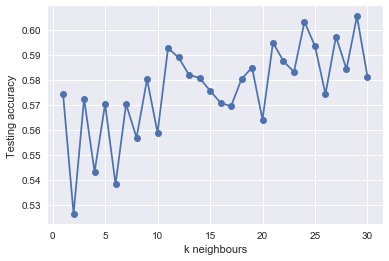

In [14]:
nb_range = np.arange(1, 31)
a_scores = []

for nb in nb_range:
    model = KNeighborsClassifier(n_neighbors=nb)
    a_scores.append(trainer.train_and_test(model))
    
plt.plot(nb_range, a_scores, 'o-')
plt.ylabel('Testing accuracy')
plt.xlabel('k neighbours')

In [15]:
from sklearn.grid_search import GridSearchCV

/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [16]:
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X, y)


# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

NameError: name 'X' is not defined

# Ensemble

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
from sklearn.ensemble import BaggingClassifier
print(train_and_test(BaggingClassifier(grid.best_estimator_, max_samples=0.5, max_features=0.5), df))

In [ ]:
print(train_and_test(BaggingClassifier(DecisionTreeRegressor()), df))

In [ ]:
print(train_and_test(BaggingClassifier(LogisticRegression()), df))

In [ ]:
print(train_and_test(BaggingClassifier(KNeighborsClassifier(n_neighbors=15)), df))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
print(train_and_test(RandomForestClassifier(n_estimators=20), df))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
print(train_and_test(AdaBoostClassifier(n_estimators=100), df))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
print(train_and_test( GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=4, random_state=0), df))

In [ ]:
from sklearn.svm import LinearSVC
model = LinearSVC(loss='l2', penalty="l2",dual=False, tol=1e-4)
print(train_and_test(model, df))

In [ ]:
model.decision_function

In [ ]:
from sklearn.neural_network import MLPClassifier
print(train_and_test(MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,), random_state=1), df))